# IERG 5350 Assignment 4: Advanced Algorithms for Continuous Control in RL

### Welcome to assignment 4 of our RL course!
*2020-2021 Term 1, IERG 5350: Reinforcement Learning. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao, SUN Hao, ZHAN Xiaohang.*


| Student Name | Student ID |
| :----: | :----: |
| Ruikang Zhang | 1155150526 |

------


In this assignment, we will implement a system of RL that allows us to train and evaluate RL agents formally and efficiently.

In this notebook, you will go through the following components of the whole system:
- Preparation: Colab, and Environment
- Section 1: Training with algorithm PPO
- Section 2: Training with algorithm DDPG
- Section 3: Training with algorithm TD3
- Section 4: Transfer your PPO/ DDPG/ TD3 to another task: Four-Solution-Maze

The author of this assignment is SUN, Hao (sh018 AT ie.cuhk.edu.hk).

# Colab

### Introduction to Google Colab: 
From now on, our assignment as well as the final project will be based on the Google Colab, where you can apply for free GPU resources to accelerate the learning of your RL models. 

Here are some resources as intro to the Colab.

- YouTube Video: https://www.youtube.com/watch?v=inN8seMm7UI
- Colab Intro: https://colab.research.google.com/notebooks/intro.ipynb
(you may need to login with your google account)




# Gym Continuous Control Tasks

### Introduction to the Gym Continuous Control Envirionments

In the last assignment, you have already used the gym[atari] benchmarks, where the action space is discrete so that normal approach is value-based methods e.g., DQN.

In this assignment, we will try to implement three prevailing RL algorithms for continuous control tasks, namely the PPO(https://arxiv.org/abs/1707.06347), DDPG(https://arxiv.org/abs/1509.02971) and TD3(https://arxiv.org/abs/1802.09477).

We will now begin with a gym environment for continuous control,

The Pendulum-v0






In [1]:
import gym
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
state = env.reset()
print('the state space is like', state)
print('the max and min action is: ',env.action_space.high,env.action_space.low)

'''so that you may need to use action value re-size if you want to use the tanh activation functions'''

the state space is like [ 0.59768775 -0.80172898  0.48203772]
the max and min action is:  [2.] [-2.]


'so that you may need to use action value re-size if you want to use the tanh activation functions'

# PPO 

The Proximal Policy Optimization Algorithms is the most prevailing on-policy learning method. Although its sample efficiency is not as high as the off-policy methods, the PPO is relatively easy to implement and the learning is much more stable than off-policy methods. Whenever you have a task you want to try whether RL works, you may try to run a PPO agent at first. It is worth mentioning even the most challenging game, the StarCraftII agent AlphaStar is trained based on PPO (with lots of improvements, ofcourse).


## TODOs for You
The ppo has the benfitsof trust region policy optimization (TRPO) but is much simpler to implement, and with some implementation engeneering, the sample complexity of TRPO is further improved.

The key idea of PPO optimization is *Not Optimize the Policy Too Much in a Certain Step*, which follows the key insight of the method of TRPO.

In TRPO, the optimization objective of policy is to learn a policy such that 

$$\max_\theta \hat{\mathbb{E}}_t [\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$

subject to 

$$\hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(\cdot|s_t),\pi_\theta(\cdot|s_t)]] \le \delta$$

where $\hat{A}$ denotes the advantage function, rather than optimize the objective function of 

$$L^{PG}(\theta) = \hat{\mathbb{E}}_t[\log \pi_\theta(a_t|s_t)\hat{A}_t]$$

in the normal policy gradint methods.

The PPO proposed two alternative approaches to solve the constrained optimization above, namely the Clipped Surrogated Objective and the Adaptive KL penalty Coefficient. The former one is more generally used in practice as it's more convenient to implement, more efficient and owns stable performance.

The Clipped Surrogated Objective approach replace the surrogate objective

$$L^{CPI}(\theta) = \hat{\mathbb{E}}_t[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}_t[r_t(\theta)\hat{A}_t]$$

of TRPO (CPI: Conservative Policy Iteration) by 

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

You can check that $L^{CLIP}(\theta) = L^{CPI}(\theta)$ around the old policy parameter $\theta_{old}$, i.e., when r = 1.

## TODOs here:

In this section, your task is to finish the code of a PPO algorithm and evaluate its performance in the Pendulum-v0 environment.

Specifically, you need to
- Q1. finish building up the ActorCritic ''\__init__'' function, i.e., build up the neural network.
- Q2. finish the foward function, in this part, there are two functions need to finish: the \_forward_actor function and the \_forward_critic function
- Q3. finish the select_action function, which is called during interacting with the environment, so that you may need to return an action as well as the (log-)probability of getting that action for future optimization
- Q4. finish the optimization steps for your PPO agent, that means you need to build up the surrogate loss through your saved tuples in previous episodes and optimize it with current network parameters.
- Q5. finally, you may need to optimize some of the hyper-parameters to have a better task performance. 

In [3]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = gym.make(ENV_NAME)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    hid_num = 256
    drop_prob = 0.1
    env_name = ENV_NAME
    seed = 1234
    num_episode = 1000
    batch_size = 5120
    max_step_per_round = 2000
    gamma = 0.995
    lamda = 0.97
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 256
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = False
    advantage_norm = True
    lossvalue_norm = True

In [4]:
# You need not to rivese this, these classes are used for normalization
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

In [6]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(num_inputs,400)
        self.actor_fc2 = nn.Linear(400,300)
        self.actor_fc3 = nn.Linear(300,num_outputs)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))#作为参数参与优化{{0,0,0,0......}}

        self.critic_fc1 = nn.Linear(num_inputs,400)
        self.critic_fc2 = nn.Linear(400,300)
        self.critic_fc3 = nn.Linear(300,num_outputs)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)#参数初始化-正交矩阵orthogonal matrix
        torch.nn.init.constant_(layer.bias, bias_const)#固定值fixed is bias_count

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        
        action_mean = self.actor_fc3(F.relu(self.actor_fc2(F.relu(self.actor_fc1(states)))))
        action_logstd = self.actor_logstd.expand_as(action_mean)#size of actor_logstd will be same with action_mean
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''

        critic_value = self.critic_fc3(F.relu(self.critic_fc2(F.relu(self.critic_fc1(states)))))
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std=torch.exp(action_logstd)
        normal_distribution=torch.distributions.normal.Normal(action_mean,action_std)
        action=normal_distribution.sample()
        logproba=normal_distribution.log_prob(action)
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''
        std=torch.exp(logstd)
        normal_distribution=torch.distributions.normal.Normal(mean,std)
        logproba=normal_distribution.log_prob(x)
        return logproba.sum(1)#对行求和

    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()#为什么要换成cpu
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
    env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]#3
    num_actions = env.action_space.shape[0]#1

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0 

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):#num_episode=1000
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:#batch_size=5120
            state = env.reset()#narray [a,c,b]
            #????
            if args.state_norm:#false
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):#2000
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))#unsqueeze add dimension=[[a,b,c]]
                #all tensor action_mean[[a]],action_logstd[[a]],value[[a]]
                action, logproba = network.select_action(action_mean, action_logstd)
                #all tensor action[[a]],logproba[[a]]
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done, _ = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)
                #state=narrray[a.b.c], value=tensor[a], action=narray[a], logproba=narray[a], mask=float, next_state=state, reward=float

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)

        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)#5200

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        #rewards=tensor[a,b,c....5200个]
        values = Tensor(batch.value)
        #values=[5200]
        masks = Tensor(batch.mask)
        #masks=[5200]
        actions = Tensor(batch.action)
        #actions=[5200,1]
        states = Tensor(batch.state)
        #states=[5200,3]
        oldlogproba = Tensor(batch.logproba)
        #oldlogproba=[5200,1]

        #print(rewards)
        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):#5200-0
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        #returns.size()=[5200],deltas.size()=[5200],advantages.size()=[5200]
        if args.advantage_norm:#true
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):#10*5200/256=200
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)#从0-5200选256个数
            #minibatch_ind=narray[256]
            minibatch_states = states[minibatch_ind]
            #minibatch_states.size()=tensor[256,3]
            minibatch_actions = actions[minibatch_ind]
            #minibatch_actions.size()=tensor[256,1]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            #minibatch_oldlogproba.size()=[256.1]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            #minibatch_newlogproba.size()=tensor[256]
            minibatch_advantages = advantages[minibatch_ind]
            #minibatch_advantages.size()=tensor[256]
            minibatch_returns = returns[minibatch_ind]
            #minibatch_returns.size()=tensor[256]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()
            #minibatch_newvalues.size()=tensor[256]



            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            minibatch_loss_surr=Tensor(args.minibatch_size)
            #minibatch_loss_surr.size()=tensor[256]
            #print(minibatch_oldlogproba.view(-1).size())
            ratio=torch.exp(minibatch_newlogproba)/torch.exp(minibatch_oldlogproba.view(-1))
            for i in range(args.minibatch_size):
                if minibatch_advantages[i] >0:
                    minibatch_loss_surr[i] = min(ratio[i],1+args.clip)*minibatch_advantages[i]
                else:
                    minibatch_loss_surr[i] = max(ratio[i],1-args.clip)*minibatch_advantages[i]
            loss_surr=torch.mean(minibatch_loss_surr)
            #print(loss_surr) tensor a 0维
           
            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)
            #print(loss_value,loss_entropy) 都是0维
            
            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        args.env_name = envname
        test(args)

torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_new_{0}hidden_{1}drop_prob'.format(args.hid_num,args.drop_prob)) 
np.savetxt(args.env_name.split('-')[0]+'/Rwds/rwds_new_{0}hidden_{1}drop_prob'.format(args.hid_num,args.drop_prob),rwds)

Finished episode: 0 Reward: -1237.4805 total_loss = 46.7091 = -0.2857 + 0.5 * 93.9911 + 0.01 * -0.0770
-----------------
Finished episode: 1 Reward: -1785.9216 total_loss = 31.4105 = -0.2742 + 0.5 * 63.3702 + 0.01 * -0.0357
-----------------
Finished episode: 2 Reward: -1476.4652 total_loss = 21.6972 = -0.4155 + 0.5 * 44.2266 + 0.01 * -0.0565
-----------------
Finished episode: 3 Reward: -1506.3947 total_loss = 28.3271 = -0.3391 + 0.5 * 57.3348 + 0.01 * -0.1185
-----------------
Finished episode: 4 Reward: -1351.1218 total_loss = 22.7980 = -0.6169 + 0.5 * 46.8309 + 0.01 * -0.0584
-----------------
Finished episode: 5 Reward: -1374.9007 total_loss = 24.2738 = -0.2735 + 0.5 * 49.0966 + 0.01 * -0.1041
-----------------
Finished episode: 6 Reward: -1404.0280 total_loss = 25.1256 = -0.5126 + 0.5 * 51.2772 + 0.01 * -0.0404
-----------------
Finished episode: 7 Reward: -1511.0193 total_loss = 25.7030 = -0.4036 + 0.5 * 52.2143 + 0.01 * -0.0507
-----------------
Finished episode: 8 Reward: -150

Finished episode: 68 Reward: -1429.1425 total_loss = 22.2076 = -0.2527 + 0.5 * 44.9199 + 0.01 * 0.0299
-----------------
Finished episode: 69 Reward: -1452.6503 total_loss = 20.9555 = -0.2957 + 0.5 * 42.5026 + 0.01 * -0.0077
-----------------
Finished episode: 70 Reward: -1402.5377 total_loss = 21.7817 = -0.4631 + 0.5 * 44.4890 + 0.01 * 0.0376
-----------------
Finished episode: 71 Reward: -1420.2661 total_loss = 21.7473 = -0.2988 + 0.5 * 44.0925 + 0.01 * -0.0128
-----------------
Finished episode: 72 Reward: -1433.3672 total_loss = 20.7301 = -0.3602 + 0.5 * 42.1825 + 0.01 * -0.0942
-----------------
Finished episode: 73 Reward: -1392.5366 total_loss = 19.5742 = -0.2782 + 0.5 * 39.7038 + 0.01 * 0.0452
-----------------
Finished episode: 74 Reward: -1331.6514 total_loss = 19.0632 = -0.3031 + 0.5 * 38.7326 + 0.01 * -0.0001
-----------------
Finished episode: 75 Reward: -1467.3975 total_loss = 21.3292 = -0.3788 + 0.5 * 43.4154 + 0.01 * 0.0268
-----------------
Finished episode: 76 Reward:

Finished episode: 136 Reward: -1467.7980 total_loss = 20.8272 = -0.2902 + 0.5 * 42.2348 + 0.01 * -0.0000
-----------------
Finished episode: 137 Reward: -1450.2422 total_loss = 19.3711 = -0.3065 + 0.5 * 39.3553 + 0.01 * -0.0000
-----------------
Finished episode: 138 Reward: -1428.2647 total_loss = 19.1088 = -0.2945 + 0.5 * 38.8052 + 0.01 * 0.0760
-----------------
Finished episode: 139 Reward: -1414.3741 total_loss = 20.0273 = -0.2768 + 0.5 * 40.6081 + 0.01 * 0.0000
-----------------
Finished episode: 140 Reward: -1407.9820 total_loss = 19.1433 = -0.3152 + 0.5 * 38.9157 + 0.01 * 0.0670
-----------------
Finished episode: 141 Reward: -1342.6159 total_loss = 18.2796 = -0.2948 + 0.5 * 37.1489 + 0.01 * -0.0000
-----------------
Finished episode: 142 Reward: -1452.1412 total_loss = 20.1606 = -0.2830 + 0.5 * 40.8872 + 0.01 * -0.0003
-----------------
Finished episode: 143 Reward: -1371.3782 total_loss = 17.4013 = -0.3063 + 0.5 * 35.4153 + 0.01 * -0.0000
-----------------
Finished episode: 1

Finished episode: 203 Reward: -1437.6504 total_loss = 20.1067 = -0.2716 + 0.5 * 40.7553 + 0.01 * 0.0660
-----------------
Finished episode: 204 Reward: -1484.3251 total_loss = 19.5058 = -0.2771 + 0.5 * 39.5657 + 0.01 * -0.0000
-----------------
Finished episode: 205 Reward: -1427.2525 total_loss = 18.1607 = -0.2878 + 0.5 * 36.8970 + 0.01 * -0.0000
-----------------
Finished episode: 206 Reward: -1394.2169 total_loss = 18.1382 = -0.2906 + 0.5 * 36.8575 + 0.01 * -0.0000
-----------------
Finished episode: 207 Reward: -1472.6660 total_loss = 20.6506 = -0.3041 + 0.5 * 41.9090 + 0.01 * 0.0222
-----------------
Finished episode: 208 Reward: -1417.2401 total_loss = 20.0354 = -0.3063 + 0.5 * 40.6835 + 0.01 * 0.0000
-----------------
Finished episode: 209 Reward: -1451.7513 total_loss = 20.1160 = -0.3299 + 0.5 * 40.8912 + 0.01 * 0.0329
-----------------
Finished episode: 210 Reward: -1474.6890 total_loss = 18.6364 = -0.3283 + 0.5 * 37.9280 + 0.01 * 0.0644
-----------------
Finished episode: 211

Finished episode: 270 Reward: -1426.9853 total_loss = 18.6047 = -0.3113 + 0.5 * 37.8304 + 0.01 * 0.0746
-----------------
Finished episode: 271 Reward: -1436.3296 total_loss = 19.8261 = -0.2571 + 0.5 * 40.1665 + 0.01 * -0.0000
-----------------
Finished episode: 272 Reward: -1468.3466 total_loss = 19.7641 = -0.2723 + 0.5 * 40.0703 + 0.01 * 0.1264
-----------------
Finished episode: 273 Reward: -1481.2083 total_loss = 19.7989 = -0.3058 + 0.5 * 40.2095 + 0.01 * -0.0000
-----------------
Finished episode: 274 Reward: -1479.3009 total_loss = 19.7015 = -0.3000 + 0.5 * 40.0031 + 0.01 * 0.0000
-----------------
Finished episode: 275 Reward: -1437.7748 total_loss = 19.3228 = -0.3189 + 0.5 * 39.2834 + 0.01 * -0.0000
-----------------
Finished episode: 276 Reward: -1456.7015 total_loss = 19.7988 = -0.3294 + 0.5 * 40.2565 + 0.01 * -0.0000
-----------------
Finished episode: 277 Reward: -1471.7599 total_loss = 18.1275 = -0.2890 + 0.5 * 36.8329 + 0.01 * -0.0000
-----------------
Finished episode: 2

Finished episode: 337 Reward: -1361.6465 total_loss = 17.9754 = -0.2972 + 0.5 * 36.5346 + 0.01 * 0.5335
-----------------
Finished episode: 338 Reward: -1442.9846 total_loss = 20.2432 = -0.2759 + 0.5 * 41.0381 + 0.01 * -0.0000
-----------------
Finished episode: 339 Reward: -1408.1472 total_loss = 15.7187 = -0.3115 + 0.5 * 32.0574 + 0.01 * 0.1488
-----------------
Finished episode: 340 Reward: -1442.7708 total_loss = 19.4498 = -0.2789 + 0.5 * 39.4573 + 0.01 * -0.0000
-----------------
Finished episode: 341 Reward: -1475.2489 total_loss = 19.7954 = -0.2764 + 0.5 * 40.1437 + 0.01 * -0.0000
-----------------
Finished episode: 342 Reward: -1423.5486 total_loss = 19.0127 = -0.2951 + 0.5 * 38.6156 + 0.01 * -0.0000
-----------------
Finished episode: 343 Reward: -1488.8927 total_loss = 22.5846 = -0.3157 + 0.5 * 45.8006 + 0.01 * 0.0000
-----------------
Finished episode: 344 Reward: -1413.2226 total_loss = 19.0819 = -0.3061 + 0.5 * 38.7761 + 0.01 * -0.0000
-----------------
Finished episode: 3

Finished episode: 404 Reward: -1397.2271 total_loss = 17.8059 = -0.3214 + 0.5 * 36.2278 + 0.01 * 1.3441
-----------------
Finished episode: 405 Reward: -1478.2711 total_loss = 20.5978 = -0.3141 + 0.5 * 41.8219 + 0.01 * 0.0965
-----------------
Finished episode: 406 Reward: -1401.7871 total_loss = 18.9366 = -0.2727 + 0.5 * 38.3951 + 0.01 * 1.1793
-----------------
Finished episode: 407 Reward: -1394.2973 total_loss = 19.9795 = -0.3113 + 0.5 * 40.5719 + 0.01 * 0.4751
-----------------
Finished episode: 408 Reward: -1459.9675 total_loss = 19.7157 = -0.3435 + 0.5 * 40.1142 + 0.01 * 0.2127
-----------------
Finished episode: 409 Reward: -1488.4421 total_loss = 21.7583 = -0.2817 + 0.5 * 44.0801 + 0.01 * -0.0000
-----------------
Finished episode: 410 Reward: -1393.6482 total_loss = 18.4028 = -0.2880 + 0.5 * 37.3817 + 0.01 * -0.0000
-----------------
Finished episode: 411 Reward: -1446.8386 total_loss = 21.5386 = -0.3022 + 0.5 * 43.6383 + 0.01 * 2.1698
-----------------
Finished episode: 412 

Finished episode: 471 Reward: -1359.1580 total_loss = 17.5813 = -0.3077 + 0.5 * 35.7780 + 0.01 * -0.0000
-----------------
Finished episode: 472 Reward: -1510.9126 total_loss = 18.9423 = -0.3007 + 0.5 * 38.4860 + 0.01 * -0.0000
-----------------
Finished episode: 473 Reward: -1470.7318 total_loss = 19.8098 = -0.3087 + 0.5 * 40.2371 + 0.01 * 0.0000
-----------------
Finished episode: 474 Reward: -1376.5026 total_loss = 17.1442 = -0.3010 + 0.5 * 34.8841 + 0.01 * 0.3082
-----------------
Finished episode: 475 Reward: -1384.2734 total_loss = 18.2684 = -0.2895 + 0.5 * 37.1158 + 0.01 * 0.0000
-----------------
Finished episode: 476 Reward: -1485.2423 total_loss = 21.5180 = -0.3053 + 0.5 * 43.6465 + 0.01 * -0.0000
-----------------
Finished episode: 477 Reward: -1375.2573 total_loss = 19.5254 = -0.3022 + 0.5 * 39.6513 + 0.01 * 0.1910
-----------------
Finished episode: 478 Reward: -1434.8974 total_loss = 18.2033 = -0.2918 + 0.5 * 36.9818 + 0.01 * 0.4165
-----------------
Finished episode: 479

Finished episode: 538 Reward: -1561.1824 total_loss = 21.7402 = -0.3289 + 0.5 * 44.1327 + 0.01 * 0.2829
-----------------
Finished episode: 539 Reward: -1567.5721 total_loss = 21.0866 = -0.3222 + 0.5 * 42.8144 + 0.01 * 0.1537
-----------------
Finished episode: 540 Reward: -1568.2441 total_loss = 20.8436 = -0.3417 + 0.5 * 42.3598 + 0.01 * 0.5400
-----------------
Finished episode: 541 Reward: -1544.9485 total_loss = 20.2150 = -0.2974 + 0.5 * 41.0249 + 0.01 * -0.0000
-----------------
Finished episode: 542 Reward: -1577.0382 total_loss = 19.4041 = -0.3079 + 0.5 * 39.4196 + 0.01 * 0.2280
-----------------
Finished episode: 543 Reward: -1542.4434 total_loss = 19.2062 = -0.3546 + 0.5 * 39.1168 + 0.01 * 0.2362
-----------------
Finished episode: 544 Reward: -1546.2023 total_loss = 20.2638 = -0.3172 + 0.5 * 41.1567 + 0.01 * 0.2681
-----------------
Finished episode: 545 Reward: -1577.5276 total_loss = 20.8998 = -0.3364 + 0.5 * 42.4725 + 0.01 * -0.0004
-----------------
Finished episode: 546 

Finished episode: 605 Reward: -1587.7331 total_loss = 20.6059 = -0.3380 + 0.5 * 41.8877 + 0.01 * -0.0000
-----------------
Finished episode: 606 Reward: -1597.0890 total_loss = 19.2620 = -0.3001 + 0.5 * 39.1242 + 0.01 * 0.0006
-----------------
Finished episode: 607 Reward: -1597.1468 total_loss = 18.7220 = -0.3125 + 0.5 * 38.0690 + 0.01 * -0.0000
-----------------
Finished episode: 608 Reward: -1601.3834 total_loss = 19.3770 = -0.3374 + 0.5 * 39.4247 + 0.01 * 0.1967
-----------------
Finished episode: 609 Reward: -1595.9657 total_loss = 20.7104 = -0.3159 + 0.5 * 42.0526 + 0.01 * 0.0027
-----------------
Finished episode: 610 Reward: -1586.8859 total_loss = 20.0306 = -0.3216 + 0.5 * 40.7044 + 0.01 * -0.0000
-----------------
Finished episode: 611 Reward: -1579.7790 total_loss = 21.3980 = -0.2982 + 0.5 * 43.3908 + 0.01 * 0.0811
-----------------
Finished episode: 612 Reward: -1559.8568 total_loss = 22.0840 = -0.2959 + 0.5 * 44.7597 + 0.01 * -0.0000
-----------------
Finished episode: 61

Finished episode: 672 Reward: -1590.0499 total_loss = 20.0027 = -0.3395 + 0.5 * 40.6835 + 0.01 * 0.0436
-----------------
Finished episode: 673 Reward: -1571.6949 total_loss = 20.6509 = -0.3159 + 0.5 * 41.9299 + 0.01 * 0.1820
-----------------
Finished episode: 674 Reward: -1602.7331 total_loss = 19.8916 = -0.3522 + 0.5 * 40.4841 + 0.01 * 0.1731
-----------------
Finished episode: 675 Reward: -1571.1324 total_loss = 21.7088 = -0.3238 + 0.5 * 44.0607 + 0.01 * 0.2172
-----------------
Finished episode: 676 Reward: -1583.7259 total_loss = 18.9006 = -0.2998 + 0.5 * 38.4007 + 0.01 * -0.0000
-----------------
Finished episode: 677 Reward: -1593.5836 total_loss = 19.9486 = -0.3140 + 0.5 * 40.5252 + 0.01 * -0.0000
-----------------
Finished episode: 678 Reward: -1569.0714 total_loss = 18.9283 = -0.3100 + 0.5 * 38.4765 + 0.01 * -0.0000
-----------------
Finished episode: 679 Reward: -1561.4632 total_loss = 19.8589 = -0.3390 + 0.5 * 40.3948 + 0.01 * 0.0516
-----------------
Finished episode: 680

Finished episode: 739 Reward: -1532.7169 total_loss = 18.3652 = -0.3086 + 0.5 * 37.3478 + 0.01 * -0.0007
-----------------
Finished episode: 740 Reward: -1454.6163 total_loss = 17.1703 = -0.4418 + 0.5 * 35.2006 + 0.01 * 1.1754
-----------------
Finished episode: 741 Reward: -1544.3691 total_loss = 18.5033 = -0.3144 + 0.5 * 37.6354 + 0.01 * -0.0015
-----------------
Finished episode: 742 Reward: -1551.8145 total_loss = 18.6912 = -0.3372 + 0.5 * 38.0567 + 0.01 * -0.0015
-----------------
Finished episode: 743 Reward: -1566.8441 total_loss = 19.4206 = -0.2933 + 0.5 * 39.4277 + 0.01 * -0.0000
-----------------
Finished episode: 744 Reward: -1567.3505 total_loss = 19.4259 = -0.2931 + 0.5 * 39.4380 + 0.01 * -0.0012
-----------------
Finished episode: 745 Reward: -1568.0573 total_loss = 19.3789 = -0.3141 + 0.5 * 39.3860 + 0.01 * -0.0000
-----------------
Finished episode: 746 Reward: -1568.0968 total_loss = 20.2468 = -0.3182 + 0.5 * 41.1300 + 0.01 * -0.0000
-----------------
Finished episode:

Finished episode: 806 Reward: -1591.9633 total_loss = 20.9469 = -0.3125 + 0.5 * 42.5083 + 0.01 * 0.5305
-----------------
Finished episode: 807 Reward: -1582.4556 total_loss = 18.9359 = -0.3910 + 0.5 * 38.6362 + 0.01 * 0.8779
-----------------
Finished episode: 808 Reward: -1565.7728 total_loss = 18.9029 = -0.3581 + 0.5 * 38.5220 + 0.01 * -0.0000
-----------------
Finished episode: 809 Reward: -1550.1313 total_loss = 19.4785 = -0.3426 + 0.5 * 39.6156 + 0.01 * 1.3287
-----------------
Finished episode: 810 Reward: -1570.4997 total_loss = 18.6101 = -0.2955 + 0.5 * 37.7899 + 0.01 * 1.0628
-----------------
Finished episode: 811 Reward: -1568.4874 total_loss = 18.2227 = -0.2775 + 0.5 * 36.9453 + 0.01 * 2.7472
-----------------
Finished episode: 812 Reward: -1561.3845 total_loss = 19.4028 = -0.3080 + 0.5 * 39.4125 + 0.01 * 0.4582
-----------------
Finished episode: 813 Reward: -1561.6114 total_loss = 16.9683 = -0.4392 + 0.5 * 34.7860 + 0.01 * 1.4440
-----------------
Finished episode: 814 R

Finished episode: 874 Reward: -1566.9732 total_loss = 20.4225 = -0.2683 + 0.5 * 41.3799 + 0.01 * 0.0812
-----------------
Finished episode: 875 Reward: -1553.5623 total_loss = 17.5541 = -0.3218 + 0.5 * 35.7451 + 0.01 * 0.3328
-----------------
Finished episode: 876 Reward: -1516.0604 total_loss = 16.4444 = -0.3523 + 0.5 * 33.5852 + 0.01 * 0.4161
-----------------
Finished episode: 877 Reward: -1570.4337 total_loss = 20.7457 = -0.3226 + 0.5 * 42.1311 + 0.01 * 0.2815
-----------------
Finished episode: 878 Reward: -1531.6499 total_loss = 18.1689 = -0.3223 + 0.5 * 36.9823 + 0.01 * 0.0104
-----------------
Finished episode: 879 Reward: -1505.1171 total_loss = 19.1973 = -0.3084 + 0.5 * 39.0002 + 0.01 * 0.5564
-----------------
Finished episode: 880 Reward: -1550.0879 total_loss = 19.6558 = -0.3278 + 0.5 * 39.9650 + 0.01 * 0.1183
-----------------
Finished episode: 881 Reward: -1537.9043 total_loss = 18.4472 = -0.3325 + 0.5 * 37.5560 + 0.01 * 0.1701
-----------------
Finished episode: 882 Re

Finished episode: 942 Reward: -1575.7748 total_loss = 19.5548 = -0.3279 + 0.5 * 39.7537 + 0.01 * 0.5835
-----------------
Finished episode: 943 Reward: -1567.5248 total_loss = 20.5300 = -1.1095 + 0.5 * 43.2650 + 0.01 * 0.6956
-----------------
Finished episode: 944 Reward: -1608.8994 total_loss = 21.5253 = -0.3123 + 0.5 * 43.6723 + 0.01 * 0.1417
-----------------
Finished episode: 945 Reward: -1560.0426 total_loss = 18.4493 = -0.2914 + 0.5 * 37.4647 + 0.01 * 0.8333
-----------------
Finished episode: 946 Reward: -1564.5237 total_loss = 18.8133 = -0.3462 + 0.5 * 38.2950 + 0.01 * 1.2015
-----------------
Finished episode: 947 Reward: -1574.3317 total_loss = 19.4804 = -0.3011 + 0.5 * 39.5336 + 0.01 * 1.4687
-----------------
Finished episode: 948 Reward: -1545.3433 total_loss = 19.1735 = -0.3360 + 0.5 * 38.9977 + 0.01 * 1.0626
-----------------
Finished episode: 949 Reward: -1591.1893 total_loss = 19.4005 = -0.3888 + 0.5 * 39.5593 + 0.01 * 0.9567
-----------------
Finished episode: 950 Re

# DDPG and TD3

The Deterministic Policy Gradient method was proposed by Silver et. al. 2014 (http://proceedings.mlr.press/v32/silver14.pdf), and DDPG is its deep version.

The DPG also uses the actor-critic paradigm, but maitains a deterministic version of policy. It optimizes the critic through the Bellman Equation, and optimize the actor through the chain rule. 

In this assignment, you may need to import some python files like DDPG.py and TD3.py to insert the method into training.
Here are some solutions from stackoverflow: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab.

It is easier to just copy it from Drive than upload it.
1. Store MYLIB.py in your Drive. (for this assignment, it will be the utils.py, DDPG.py and TD3.py)
2. Open the Colab.
3. Open the left side pane, select Files view (the file icon).
4. Click Mount Drive then Connect to Google Drive (the folder with google drive icon).
5. Copy it by running "! cp drive/My\ Drive/MYLIB.py . " in your Colab file code line.
6. import MYLIB




## TODOs for You (Please write down the answer in this block)

The TD3 is short for *Twin Delayed Deep Deterministic Policy Gradient*, their official open-source implementation is extremely clear and easy to follow! So I believe there is no need for you to build up the wheels one more time.

However, you really need to know about how this method works!
TD3 proposes several improvements based on the method of DDPG to improve its sample efficiency.

- Q6. In this part, your task is to read the paper, and read the code of the official implementation of TD3 and DDPG at:

https://github.com/sfujim/TD3/blob/master/DDPG.py

https://github.com/sfujim/TD3/blob/master/TD3.py

Then, please try to find the proposed improvements in TD3 over DDPG and summary them HERE:

1. TD3 learns two Q-functions instead of one(DDPG learns one).and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.
    - code:
         target_Q1, target_Q2 = self.critic_target(next_state, next_action)
         target_Q = torch.min(target_Q1, target_Q2)
			 target_Q = reward + not_done * self.discount * target_Q
2. TD3 upadtes the policy less frequently than the Q-function.TD3 updates the policy after two updates of the Q-function(DDPG updates the policy for every two Q-function updates).
    - code:
        if self.total_it % self.policy_freq == 0:
			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()
			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
3. TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.
    - code:
        noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip) 
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)
3. Actor update of TD3 only depends on part of the network gradient.
     - code:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
     
- Q7. Among all those improvements, which do you believe is the most important one? You may take some ablation studies to support your claim.  (i.e., draw some learning curves with different settings together and draw your conclusions).

 In my opinion,TD3 learns two Q-functions is the most important one.Because the main problem of DDPG is that the learned Q-function sometimes dramatically overestimate Q-values, which then leads to the policy breaking.TD3 uses learning two Q-functions and selecting smaller one to solve this problem.
 
 
- Q8. What is the difference between TD3(DDPG) and PPO in the OPTIMIZATION step (including but not restricted in terms of the sampling-training proportion)? Actually the improvements of PPO over TRPO was pointed  as a benefit of more training iterations, can you further improve the sample efficiency of TD3?
 
 1- PPO use importance sampling to exploit the data.In an training phase,firstly,PPO gets all transition and put them in replay buffer,then uses part of them to train and update network.The reason why exploit the same data is because it uses importance sampling.
    TD3(DDPG) gets a transition then trains and update network,after trainning and upadating, it will get another new transition to execute next train.In a word,it will use different policy to get new data for train.
 2- TD3 optimize actor and critic seperately.PPO optimize actor and critic using a loss at the same time.
 
 To improve the sample efficiency of TD3,I think we can imitate the sampling strategy of PPO:Fristly accumulating enough trasition,Then sample the mini-batch size transitions for next train.
 

- Q9. (i) Please describe the difference of the exploration strategies between PPO, DDPG and TD3. (ii) Provide a comparison between the exploration strategies of those continuous control algorithms and DQN.

 (i)TD3：TD3 use the actor network to get the action mean and anction logstd,which represent a normal distribution,then according this distribution TD3 will select an action.
   PPO(DDPG):Before starting trainning,PPO(DDPG) will randomly select an action between the max and the min and get a transition.After starting trainning,PPO(DDPG) will get the action through actor network with certain probability then constraint this action by clip,otherwise randomly select an action between the max and the min. 
  (ii)DQN uses an epsilon-greedy algorithm to select action.It will select an action which take the maxmum value with epsilon probability and select an action randomly with 1-epsilon probability.
   The actions selected by DQN are discrete variables, while the actions TD3(DDPG) and PPO choose are continuous variables within a certain range. 
   
   
- Q10. (Bonus, 20 points) An open question. Do you think an epsilon-greedy-like exploration strategy you used in DQN/Q-learning is useful for continuous control? Will there be any problem of applying epsilon-greedy method in DDPG/TD3/PPO? Try to implement the idea and report the results.

 Yes.It is useful.I apply it with PPO,leading the higher final reward.

The following four blocks download the code in official implementation to your google drive so that the following script can run them. Note that the downloaded files may disappear due to some colab mechansim.

In [1]:
!git clone https://github.com/sfujim/TD3.git

Cloning into 'TD3'...
remote: Enumerating objects: 223, done.
remote: Total 223 (delta 0), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (223/223), 197.79 KiB | 691.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
!cp TD3/DDPG.py .

In [3]:
!cp TD3/TD3.py .

In [4]:
!cp TD3/utils.py .

In [10]:
from os import makedirs as mkdir
mkdir('results', exist_ok=True)

In [ ]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = ( 
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

In [ ]:
# The following scripts run the TD3 algorithm.

alias = 'td3'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

# Four-Solution-Maze Environment (optional)

## TODOs for you:

- Q11. (bonus) In this section, another environment named Four-Solution-Maze is provided for you to evaluate your algorithms.

The task is quite simple, yet never easy for even PPO/TD3.

The default size of the maze is 64x64, and in each game (espisode), the agent is initialized randomly in the maze. There are 4 positions in the maze that has non-trivial reward of +10, while reaching other region will recieve only a tiny punishment of -0.1. An optimal policy should be able to find the shortest path to the most recent reward region (i.e., one of the four high-reward regions.).

The action space is continuous with range [-1,1], larger actions will be clipped.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from numpy import *
import copy

class FourWayGridWorld:
    def __init__(self, N=17,left = 10,right = 10, up=10, down = 10):
        self.N = N
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.map = np.ones((N,N))*(-0.1)
        self.map[int((N-1)/2),0] = self.left
        self.map[0,int((N-1)/2)] = self.up
        self.map[N-1,int((N-1)/2)] = self.down
        self.map[int((N-1)/2),N-1] = self.right
        self.loc = np.asarray([np.random.randint(N),np.random.randint(N)])
        self.step_num = 0
    def step(self,action):
        action = np.clip(action,-1,1)
        new_loc = np.clip(self.loc + action,0,self.N-1)
        self.loc = new_loc
        reward = self.map[int(round(self.loc[0])),int(round(self.loc[1]))]
        self.step_num+=1
        return self.loc,reward,self.ifdone()
    def ifdone(self):
        if self.step_num >= 2*self.N:
            return True
        else:
            return False
    def render(self):
        map_self = copy.deepcopy(self.map)
        map_self[int(self.loc[0]),int(self.loc[1])] = -5
        plt.imshow(map_self)
    def reset(self):
        self.map = np.ones((self.N,self.N))*(-0.1)
        self.map[int((self.N-1)/2),0] = self.left
        self.map[0,int((self.N-1)/2)] = self.up
        self.map[self.N-1,int((self.N-1)/2)] = self.down
        self.map[int((self.N-1)/2),self.N-1] = self.right
        self.loc = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.step_num = 0
        return self.loc


In [ ]:
env = FourWayGridWorld(33)

In [ ]:
env.reset()

array([30,  2])

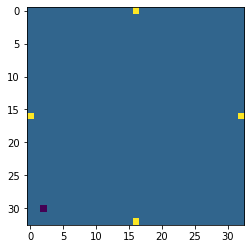

In [ ]:
env.render()

In [ ]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])